# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
64326,68707165,Qatar Retail Restaurant Assistant Managers an...,Qatar Retail Restaurant Assistant Managers an...,"Qatar, Greater London",London,NaN,NaN,COREcruitment International,Hospitality & Catering Jobs,22000-28000 Per Annum bonus + relocation + ben...,25000,jobs.catererandhotelkeeper.com,10.126671
105344,69577709,Opener Alternative Investments ****K Basic ...,Junior Broker London ****K Basic ****K OTEB...,City of London - London,The City,full_time,permanent,UKStaffsearch,Accounting & Finance Jobs,12000 - 80000,46000,ukstaffsearch.com,10.736419
146127,70729230,"Java Developer, leading ECommerce, London","Java, servlets, JSP, struts, SQL, spring, hibe...",City of london London Greater London,London,NaN,permanent,NaN,IT Jobs,60000,60000,technojobs.co.uk,11.002116


In [3]:
data['Title']

0                               Engineering Systems Analyst
1                                   Stress Engineer Glasgow
2                          Modelling and simulation analyst
3         Engineering Systems Analyst / Mathematical Mod...
4                Pioneer, Miser Engineering Systems Analyst
                                ...                        
244763                                   TEACHER OF SCIENCE
244764                  TEACHER OF BUSINESS STUDIES AND ICT
244765                                      ENGLISH TEACHER
244766                                      SUPPLY TEACHERS
244767                                           Accountant
Name: Title, Length: 244768, dtype: object

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

In [6]:
tokenizer.tokenize('engineering systems analyst')

['engineering', 'systems', 'analyst']

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
# <YOUR CODE HERE>
token_counts.update(' '.join(data["Title"]).split())
token_counts.update(' '.join(data["FullDescription"]).split())

In [10]:
# Counter(data["Title"], data['FullDescription'])

In [11]:
token_counts.most_common(1)[0][1]

2657388

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

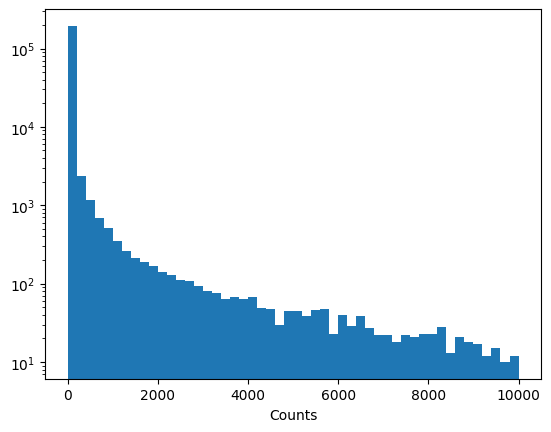

In [13]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

In [14]:
# token_counts.update(data["Title"])
# token_counts.update(data["FullDescription"])

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = <YOUR CODE HERE>
tokens = [k for k, i in token_counts.items() if i >= min_count]
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [27]:
token_to_id = {i: num for num, i in enumerate(tokens)}

In [28]:
len(token_to_id)

34158

In [29]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [30]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [31]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [32]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [33]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [34]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [35]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 808,  782,    1,    1],
        [ 165,   88,    1,    1],
        [1892,   88, 4228,  335]], dtype=int32),
 'FullDescription': array([[  561,  5385,  1617,  1566, 12962,    73,   561,   808,   782,
            55],
        [  165,    88,  1761, 32329,    94,    22,  6266,    55,  5782,
            73],
        [  110,  1464,   561,  1073,  1617,    86,  2692,   561,   101,
          1330]], dtype=int32),
 'Categorical': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.7981825, 10.146473 ,  9.998843 ], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [36]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [38]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
#         <YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [39]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [41]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# <YOUR CODE HERE>

class DescriptionsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
#         <YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [42]:
desc_encoder = DescriptionsEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [58]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionsEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
#         <YOUR CODE>
        self.dense_cat = nn.Linear(n_cat_features, 64)
        
        
        
        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>
        self.dense_output = nn.Linear(64*3, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        # desc_h = <YOUR CODE>
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        # cat_h = <YOUR CODE>
        cat_h = self.dense_cat(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        # <YOUR CODE>
        h = self.dense_output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:, 0]

In [59]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [60]:
len(prediction.shape)

1

In [61]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [62]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [63]:
model.parameters()

<generator object Module.parameters at 0x19e7f6810>

In [64]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [65]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [66]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [67]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	9.86459
	MAE:	22718.06216



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.64929
	MAE:	7632.24119



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.54631
	MAE:	6914.31654



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46450
	MAE:	6168.10423



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.43485
	MAE:	6057.61219



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.39312
	MAE:	6387.22601



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33958
	MAE:	5263.20573



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32058
	MAE:	5428.44021



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.30913
	MAE:	4985.99052



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28180
	MAE:	4740.22753



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26319
	MAE:	4708.77040



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26229
	MAE:	4913.83610



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26241
	MAE:	4630.32937



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23960
	MAE:	4626.25290



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22534
	MAE:	4391.92496



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22516
	MAE:	4166.22434



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23908
	MAE:	4348.07496



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20630
	MAE:	4162.50553



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20405
	MAE:	4215.90635



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20701
	MAE:	4468.25142



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18514
	MAE:	3951.98659



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19492
	MAE:	3883.75148



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18780
	MAE:	4004.42613



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18035
	MAE:	3942.50988



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18639
	MAE:	3992.83068



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17692
	MAE:	3756.35043



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17422
	MAE:	3913.19388



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16609
	MAE:	3704.29935



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17030
	MAE:	3730.35925



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16275
	MAE:	3637.32652



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16585
	MAE:	3847.06811



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15574
	MAE:	3722.93483



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14408
	MAE:	3526.23863



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14858
	MAE:	3593.79213



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15811
	MAE:	3760.37927



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14481
	MAE:	3550.75728



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13858
	MAE:	3474.12365



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13908
	MAE:	3450.36884



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13601
	MAE:	3418.03587



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13426
	MAE:	3469.69002



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14081
	MAE:	3563.33805



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13124
	MAE:	3404.69874



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13767
	MAE:	3450.55183



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14551
	MAE:	3863.62269



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12750
	MAE:	3286.94260



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14050
	MAE:	3743.34119



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12210
	MAE:	3287.94872



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12950
	MAE:	3514.18850



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12974
	MAE:	3414.49344



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13084
	MAE:	3593.07820



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12650
	MAE:	3464.91270



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13448
	MAE:	3324.17991



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12459
	MAE:	3408.26942



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12396
	MAE:	3454.04295



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11317
	MAE:	3269.87483



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13533
	MAE:	3754.36934



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12846
	MAE:	3485.25580



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13070
	MAE:	3317.75769



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11912
	MAE:	3265.57842



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11547
	MAE:	3176.92851



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12362
	MAE:	3311.55635



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11368
	MAE:	3240.86818



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11743
	MAE:	3216.24901



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11541
	MAE:	3174.50143



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11778
	MAE:	3301.57213



Validation:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11189
	MAE:	3158.18096



Training:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [68]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/var/folders/p6/b16fkpd508j8307_nxc17wjc0000gn/T/ipykernel_2071/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11106
	MAE:	3163.31100





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...